In [1]:
import sys, os
import numpy as np
import h5py
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tqdm.notebook import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, RepeatVector, MaxPooling2D, Conv2D, Concatenate, UpSampling2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMakerPlus import *

In [2]:
LATENT_DIM = 16
BASE_DEPTH = 8
CHANNELS = 5
IMAGE_SHAPE = (CHANNELS, 64, 64)
BATCH_SIZE = 1024
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-2

In [3]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [4]:
TRAIN_PATH = f'/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_training_z_less_than_2.hdf5'
TEST_PATH = f'/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_testing_z_less_than_2.hdf5'

gen_args = {
    'image_key': 'image',
    'numerical_keys': None,
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}
train_gen = HDF5DataGenerator(TRAIN_PATH, mode = 'train', **gen_args)
test_gen = HDF5DataGenerator(TEST_PATH, mode = 'train', **gen_args)
print(train_gen[0][0].shape) # a batch of images
print(train_gen[0][1].shape) # a batch of corresponding redshifts

(1024, 5, 64, 64)
(1024,)


In [5]:
batch_count = 0
def next_batch():
    global batch_count
    x_train = np.asarray(train_gen[batch_count][0])
    y_train = np.asarray(train_gen[batch_count][1]).reshape((BATCH_SIZE, 1))
    batch_count = batch_count + 1
    if batch_count == len(train_gen) - 1:
        batch_count = 0
    return x_train, y_train

In [6]:
def build_generator(LATENT_DIM):
    noise = Input(shape = (LATENT_DIM,))
    label = Input(shape = (1,), dtype = 'float32')
    label_embedding = Dense(LATENT_DIM)(label)
    model_input = Concatenate()([noise, label_embedding])
    
    x = Dense(1024, activation = "relu")(model_input)
    x = Dense(1024, activation = "relu")(x) # Size of the dense layer changed
    x = Dense(256 * 16 * 16, activation = "relu")(x) # Size of the dense layer changed
    x = Reshape((256, 16, 16))(x) # Reshape size changed
    x = Conv2DTranspose(128, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(x)
    x = Conv2DTranspose(64, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(x)
    x = Conv2DTranspose(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(x)
    x = Conv2DTranspose(CHANNELS, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(x)
    outputs = Reshape(IMAGE_SHAPE)(x)
    
    model = Model([noise, label], outputs)
    return model

In [7]:
def build_discriminator(IMAGE_SHAPE):
    img = Input(shape = IMAGE_SHAPE)
    label = Input(shape = (1,), dtype = 'float32')

    label_embedding = Dense(np.prod(IMAGE_SHAPE))(label)
    label_embedding = Reshape(IMAGE_SHAPE)(label_embedding)
    
    merged_input = Concatenate(axis = 1)([img, label_embedding]) # Concatenate along channels

    x = Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', data_format = 'channels_first')(merged_input)
    x = LeakyReLU(alpha = 0.01)(x)
    x = MaxPooling2D(2, 2, data_format = 'channels_first')(x)
    x = Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', data_format = 'channels_first')(x)
    x = LeakyReLU(alpha = 0.01)(x)
    x = MaxPooling2D(2, 2, data_format = 'channels_first')(x)
    x = Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', data_format = 'channels_first')(x)
    x = LeakyReLU(alpha = 0.01)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dense(128)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)

    model = Model([img, label], outputs)
    return model

In [8]:
def build_gan(generator, discriminator):
    
    discriminator.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    discriminator.trainable = False

    noise = Input(shape = (LATENT_DIM,))
    label = Input(shape = (1,))
    img = generator([noise, label])
    fake_pred = discriminator([img, label])

    combined_model = Model([noise, label], fake_pred)
    combined_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy')
    return combined_model

In [9]:
generator = build_generator(LATENT_DIM)
discriminator = build_discriminator(IMAGE_SHAPE)
gan = build_gan(generator, discriminator)

In [10]:
generator.summary()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           32          ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 32)           0           ['input_1[0][0]',                
                                                                  'dense[0][0]']              

class DummyFile(object):
    def write(self, x): pass

# Save the original standard output
original_stdout = sys.stdout

# Redirect standard output to the dummy file
sys.stdout = DummyFile()

sys.stdout = original_stdout
print("1")
# Redirect standard output back to the dummy file
sys.stdout = DummyFile()

# Training code
epochs = 1000

for epoch in range(epochs):
    
    # Train Discriminator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    fake_redshift = np.random.uniform(0, 2, (BATCH_SIZE, 1))
    fake_labels = np.zeros((BATCH_SIZE, 1))
    
    sys.stdout = original_stdout
    print("1")
    # Redirect standard output back to the dummy file
    sys.stdout = DummyFile()
    
    fake_images = generator.predict([noise, fake_redshift])
    
    sys.stdout = original_stdout
    print("1")
    # Redirect standard output back to the dummy file
    sys.stdout = DummyFile()
    
    real_images, real_redshift = next_batch() # Get a batch of real images
    real_labels = np.ones((BATCH_SIZE, 1))
    
    labels = np.vstack([real_labels, fake_labels])
    redshifts = np.vstack([real_redshift, fake_redshift])
    images = np.vstack([real_images, fake_images])
    
    sys.stdout = original_stdout
    print("1")
    # Redirect standard output back to the dummy file
    sys.stdout = DummyFile()

    d_loss = discriminator.train_on_batch([images, redshifts], labels);
    
    sys.stdout = original_stdout
    print("1")
    # Redirect standard output back to the dummy file
    sys.stdout = DummyFile()
    
    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    fake_redshift = np.random.uniform(0, 2, (BATCH_SIZE, 1)) # a vector of fake redshift to input the generator
    g_loss = gan.train_on_batch([noise, fake_redshift], real_labels); # train the generator
    
    if True: # epoch % 5 == 0:
        # Restore original standard output for printing
        sys.stdout = original_stdout
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")
        # Redirect standard output back to the dummy file
        sys.stdout = DummyFile()

# Restore original standard output after training
sys.stdout = original_stdout

32/32 [==============================] - 0s 1ms/step
Epoch 0, Discriminator Loss: [0.08813095837831497, 0.97802734375], Generator Loss: 6.17331075668335
32/32 [==============================] - 0s 1ms/step
Epoch 5, Discriminator Loss: [0.05035630241036415, 0.99609375], Generator Loss: 3.6215410232543945
32/32 [==============================] - 0s 1ms/step
Epoch 10, Discriminator Loss: [0.0594935417175293, 0.97998046875], Generator Loss: 5.097879409790039
32/32 [==============================] - 0s 1ms/step
Epoch 15, Discriminator Loss: [0.0662131980061531, 0.99658203125], Generator Loss: 4.005736351013184
32/32 [==============================] - 0s 1ms/step
Epoch 20, Discriminator Loss: [0.055432114750146866, 0.99072265625], Generator Loss: 4.696082592010498
32/32 [==============================] - 0s 1ms/step
Epoch 25, Discriminator Loss: [0.03539407253265381, 0.99462890625], Generator Loss: 4.51845645904541
32/32 [==============================] - 0s 1ms/step
Epoch 30, Discriminator 

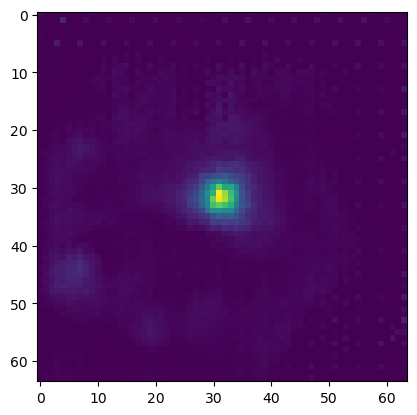

In [41]:
epochs = 100

for epoch in range(epochs):
    
    # Train Discriminator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    
    fake_redshift = np.random.uniform(0, 2, (BATCH_SIZE, 1))
    fake_labels = np.zeros((BATCH_SIZE, 1))
    fake_images = generator.predict([noise, fake_redshift])
    
    real_images, real_redshift = next_batch() # Get a batch of real images
    real_labels = np.ones((BATCH_SIZE, 1))
    
    labels = np.vstack([real_labels, fake_labels])
    redshifts = np.vstack([real_redshift, fake_redshift])
    images = np.vstack([real_images, fake_images])
    
    d_loss = discriminator.train_on_batch([images, redshifts], labels);
    
    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    fake_redshift = np.random.uniform(0, 2, (BATCH_SIZE, 1)) # a vector of fake redshift to input the generator
    g_loss = gan.train_on_batch([noise, fake_redshift], real_labels); # train the generator
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")
        
plt.imshow(fake_images[0][4])

In [42]:
model_name = 'gan'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

In [43]:
gan.save_weights(weights_path)

In [44]:
gan.load_weights(weights_path)

In [45]:
model_name = 'discriminator'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

In [46]:
discriminator.save_weights(weights_path)

In [47]:
discriminator.load_weights(weights_path)

In [12]:
# END